In [1]:
import pickle as pkl
import numpy as np
from itertools import chain
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from scipy.stats import norm

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import make_brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot, make_twcrps_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram, make_reliability_diagram_sklearn, make_reliability_and_sharpness
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_cdf, plot_forecast_pdf, plot_weight_mixture, plot_forecast_pdf_i

2024-03-28 08:56:55.878408: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 08:56:55.908566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 08:56:55.908597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 08:56:55.909653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 08:56:55.914750: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 08:56:55.915725: I tensorflow/core/platform/cpu_feature_guard.cc:1

Base model is the truncated normal distribution trained on the CRPS.

In [65]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

base_model = load_model(folder + 'trunc_normal/tn_crps__epochs600_folds_1_2.pkl')


Using given parameters for Truncated Normal distribution


In [66]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test, variances_test = get_tensors(base_model.neighbourhood_size, base_model.all_features, test_fold, ignore)
X_test = (X_test - base_model.feature_mean) / base_model.feature_std

print(X_test.shape)

(7780, 5)


In [67]:
tnf = load_model(folder + 'trunc_normal_features/tnf_crps__epochs600_folds_1_2.pkl')

ml_tn_gevf_M13_STD2_C03 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')

ml_tn_gev = load_model(folder + "mixture_linear/mixturelinear_tn_gev_sv_crps__epochs600_folds_1_2.pkl")

m_tn_gev = load_model(folder + "mixture/mixture_tn_gev_sv_crps__epochs600_folds_1_2.pkl")

ml_tn_gev_M13_STD2_C03 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_sv_twcrps_mean13.0_std2.0_constant0.029999999329447746_epochs600_folds_1_2.pkl')

m_tn_gev_M13_STD2_C03 = load_model(folder + 'mixture/mixture_tn_gev_sv_twcrps_mean13.0_std2.0_constant0.029999999329447746_epochs600_folds_1_2.pkl')

ml_tn_gev_M13_STD2 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_sv_twcrps_mean13.0_std2.0_epochs600_folds_1_2.pkl')

ml_tn_gev_M13_STD4 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_sv_twcrps_mean13.0_std4.0_epochs600_folds_1_2.pkl')

ml_tn_gev_M13_STD2_C01 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_sv_twcrps_mean13.0_std2.0_constant0.009999999776482582_epochs600_folds_1_2.pkl')

ml_tn_ln_M13_STD2_C01 = load_model(folder + 'mixture_linear/mixturelinear_tn_ln_twcrps_mean13.0_std2.0_constant0.009999999776482582_epochs600_folds_1_2.pkl')

m_tn_gev_M13_STD2 = load_model(folder + 'mixture/mixture_tn_gev_sv_twcrps_mean13.0_std2.0_epochs600_folds_1_2.pkl')

ml_tn_gev_M13_STD2_C02 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_sv_twcrps_mean13.0_std2.0_constant0.019999999552965164_epochs600_folds_1_2.pkl')


ml_tnf_gevf_M13_STD2_C01 = load_model(folder + 'mixture_linear/mixturelinear_tnf_gev_twcrps_mean13.0_std2.0_constant0.009999999776482582_epochs600_folds_1_2.pkl')

ml_tnf_gevf_M13_STD2_C03 = load_model(folder + 'mixture_linear/mixturelinear_tnf_gev_twcrps_mean13.0_std2.0_constant0.029999999329447746_epochs600_folds_1_2.pkl')

ml_tnf_gevf = load_model(folder + 'mixture_linear/mixturelinear_tnf_gev_crps__epochs600_folds_1_2.pkl')

models = {'ml_tn_gev': ml_tn_gev, 'ml_tn_gev_M13_STD2_C03': ml_tn_gev_M13_STD2_C03, 'm_tn_gev_M13_STD2_C03': m_tn_gev_M13_STD2_C03, 'ml_tn_gev_M13_STD2': ml_tn_gev_M13_STD2, 'ml_tn_gev_M13_STD4': ml_tn_gev_M13_STD4, 'ml_tn_gev_M13_STD2_C01': ml_tn_gev_M13_STD2_C01, 'ml_tn_ln_M13_STD2_C01': ml_tn_ln_M13_STD2_C01}

Using given parameters for Truncated Normal distribution with features
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution with spatial variance
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution with spatial variance
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution with spatial variance
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Ex

In [68]:
tn_M13_STD2 = load_model(folder + 'trunc_normal/tn_twcrps_mean13.0_std2.0_epochs600_folds_1_2.pkl')

gev_M13_STD2 = load_model(folder + 'gev_spatial_variance/gev_spatial_variance_twcrps_mean13.0_std2.0_epochs600_folds_1_2.pkl')

ln_M13_STD2 = load_model(folder + 'log_normal/ln_twcrps_mean13.0_std2.0_epochs600_folds_1_2.pkl')

initial_models = {'gev_M13_STD2': gev_M13_STD2, 'tn_M13_STD2': tn_M13_STD2, 'ln_M13_STD2': ln_M13_STD2}

m_tn_gev_models = {'m_tn_gev_M13_STD2': m_tn_gev_M13_STD2, 'm_tn_gev': m_tn_gev}

ml_tn_gev_models = {'ml_tn_gev' : ml_tn_gev, 'ml_tn_gev_M13_STD2' : ml_tn_gev_M13_STD2}

ml_tn_gev_C_models = {'ml_tn_gev_M13_STD2_C03': ml_tn_gev_M13_STD2_C03, 'ml_tn_gev_M13_STD2_C01': ml_tn_gev_M13_STD2_C01, 'ml_tn_gev': ml_tn_gev, 'ml_tn_gev_M13_STD2_C02': ml_tn_gev_M13_STD2_C02, 'ml_tn_gev_M13_STD4': ml_tn_gev_M13_STD4}

ml_spatial_models = {'ml_tn_gev_M13_STD2_C01': ml_tn_gev_M13_STD2_C01, 'ml_tn_ln_M13_STD2_C01': ml_tn_ln_M13_STD2_C01, 'ml_tn_gev_M13_STD2_C03': ml_tn_gev_M13_STD2_C03}

ml_tnf_gevf_models = {'ml_tnf_gevf_M13_STD2_C01': ml_tnf_gevf_M13_STD2_C01, 'ml_tnf_gevf_M13_STD2_C03': ml_tnf_gevf_M13_STD2_C03, 'ml_tnf_gevf': ml_tnf_gevf}

progression_models = {'gev_M13_STD2': gev_M13_STD2, 'm_tn_gev_M13_STD2': m_tn_gev_M13_STD2, 'ml_tn_gev_M13_STD2': ml_tn_gev_M13_STD2, 'ml_tn_gev_M13_STD2_C01': ml_tn_gev_M13_STD2_C01, 'ml_tn_gev_M13_STD2_C03' : ml_tn_gev_M13_STD2_C03}

tnf_dict = {'tnf': tnf} #'ml_tn_gevf_M13_STD2_C03': ml_tn_gevf_M13_STD2_C03}

Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution with spatial variance
Using given parameters for Log Normal distribution


In [69]:
print('The 90th percentile of the test set is:', np.percentile(y_test, 90))
print("The 95th percentile of the test set is:", np.percentile(y_test, 95))
print("The 99th percentile of the test set is:", np.percentile(y_test, 99))
print("The number of observations exceeding 17 m/s is:", np.sum(y_test > 17))

The 90th percentile of the test set is: 10.289999961853027
The 95th percentile of the test set is: 12.210000038146973
The 99th percentile of the test set is: 15.4399995803833
The number of observations exceeding 17 m/s is: 31


Last time I was able to train EMOS models on different weight functions with the twCRPS as scoring rule. 

I currently only look at the following relation between the features $X$ and the spatial variance S^2:

For the truncated normal/ log normal:

$\mu = a + bX$ 

$\sigma = c + dS^2$

For the GEV:

$\mu = a + bX$ 

$\sigma = c + dS^2$ (Maybe change this to $\log(\sigma) = c + dS^2$)

$\xi = e$

For the log-normal (with mean $m$ and variance $v$):

$m = a + bX$

$v = c + dS^2$

where $a,b$ can take any number and $c,d\geq 0$

Regarding the naming:

- tn_M13_STD2 means that the underlying distribution is the truncated normal, and it is trained on the twCRPS with as weight function a Gaussian CDF with mean 13 and standard deviation 2.

We will be using the truncated normal distribution trained on the CRPS as reference model. We obtained the following results:

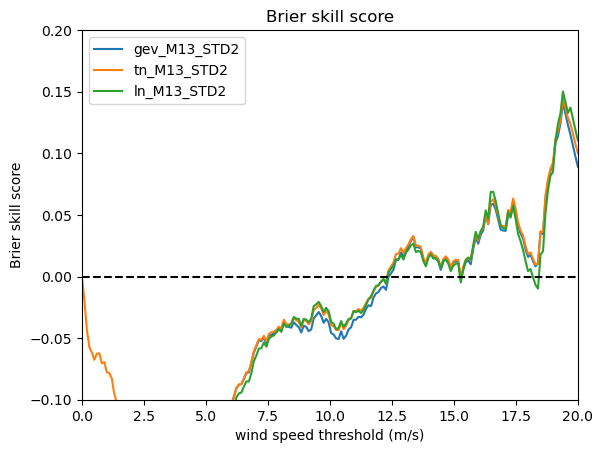

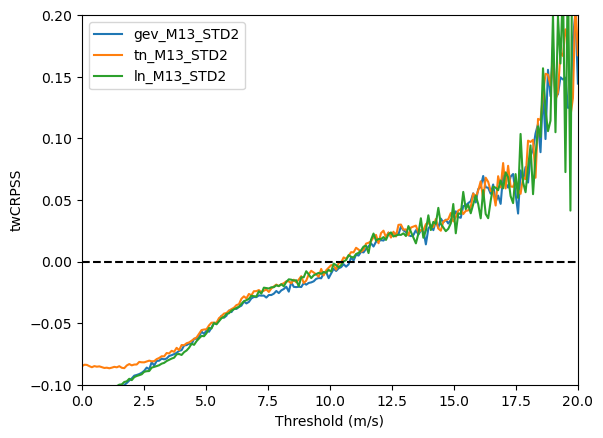

In [70]:
ylim = [-0.1, 0.2]
values = np.linspace(0,20,200)
make_brier_skill_plot(base_model, initial_models, X_test, y_test, variances_test, values, ylim=ylim)
make_twcrpss_plot(base_model, initial_models, X_test, y_test, variances_test, values, ylim=ylim)

We first consider a simple mixture model where we just take the mixture of 2 distributions (with a single weight parameter that needs to be optimized for the entire data set).

- m_tn_gev is a mixture distribution of the truncated normal and gev distribution trained on the CRPS.
- m_tn_gev is a mixture distribution of the truncated normal and gev distribution trained on the twCRPS with a Gaussian CDF as weight function with mean 13 and std 2

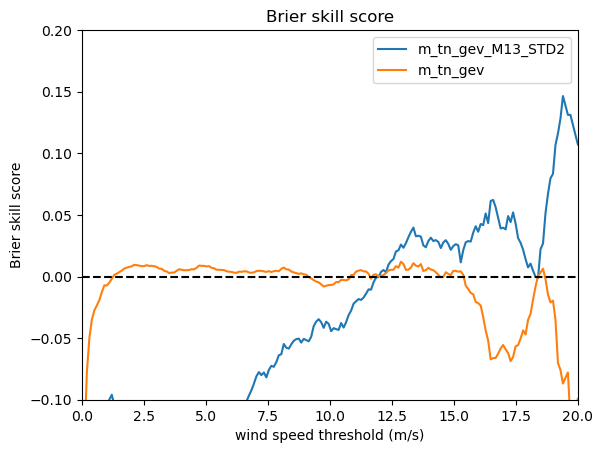

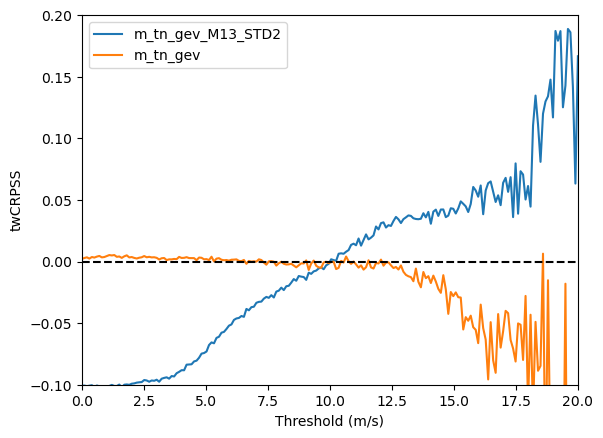

In [43]:
values = np.linspace(0,20,200)
ylim = [-0.1, 0.2]
make_brier_skill_plot(base_model, m_tn_gev_models, X_test, y_test, variances_test, values, ylim=ylim)
make_twcrpss_plot(base_model, m_tn_gev_models, X_test, y_test, variances_test, values, ylim=ylim)

Still not really what we are interested in, since it is unable to optimize for both the lower and higher wind speeds. Therefore we consider a mixture model with a variable weight parameter $w$. This will be estimated by

$w = f(a + bX_w)$

where $f$ is the sigmoid function, $X_w$ is the forecasted windspeed (we do not consider other features), and $a,b$ are real-valued parameters that our program tries to optimize. 

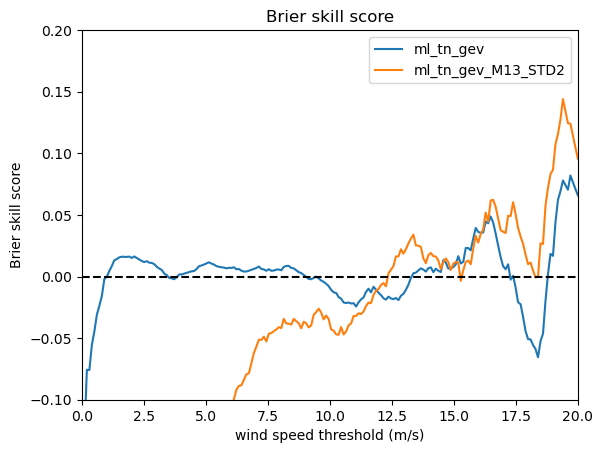

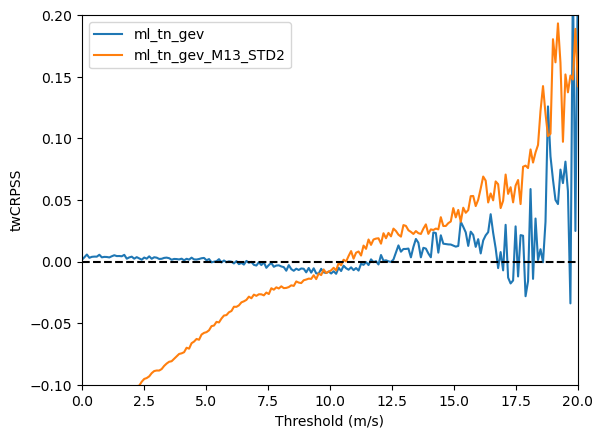

In [9]:
values = np.linspace(0,20,200)
ylim = [-0.1, 0.2]
make_brier_skill_plot(base_model, ml_tn_gev_models, X_test, y_test, variances_test, values, ylim=ylim)
make_twcrpss_plot(base_model, ml_tn_gev_models, X_test, y_test, variances_test, values, ylim=ylim)

This is already starting to look a bit better. However, with the weight function of a Gaussian CDF we are unable to train sufficiently for lower wind speeds. There are a few ways to handle this problem:

- increase the STD of the CDF
- decrease the mean of the CDF
- add a small constant to the weight function

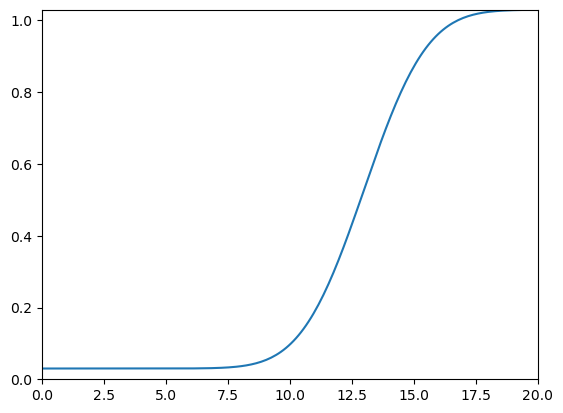

In [81]:
#plot a normal cdf
values = np.linspace(0,20,200)
loc = 13
scale = 2
constant = 0.03
normal = norm(loc=loc, scale=scale)
y_values = normal.cdf(values) + constant

plt.plot(values, y_values)
plt.xlim([0,20])
plt.ylim([0,1 + constant])
plt.show()

For the naming:

- ml_tn_gev_M13_STD2_C03: trained on the twCRPS rule with weight function of Gaussian CDF with mean 13, std 2 and a added constant of 0.03

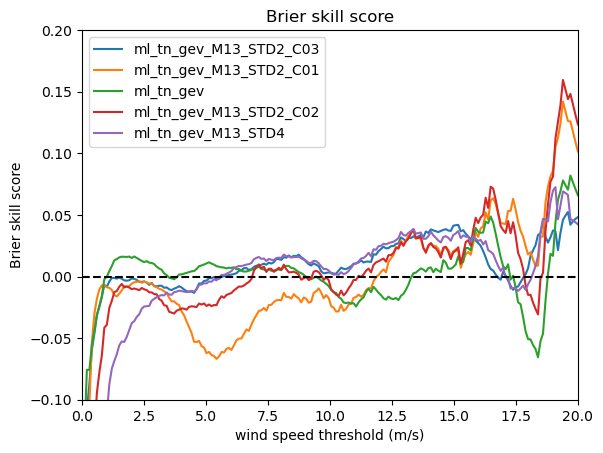

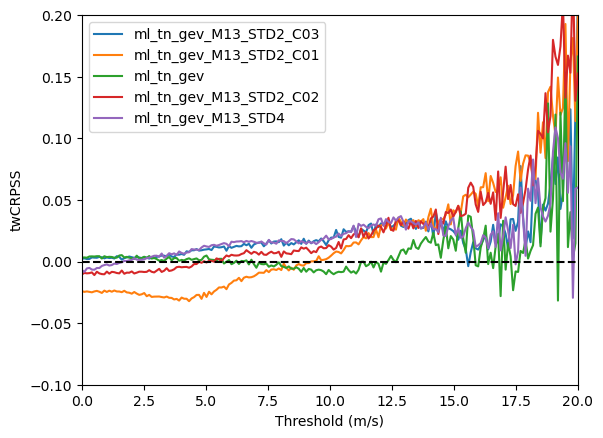

In [14]:
values = np.linspace(0,20,200)
ylim = [-0.1, 0.2]
make_brier_skill_plot(base_model, ml_tn_gev_C_models, X_test, y_test, variances_test, values, ylim=ylim)
make_twcrpss_plot(base_model, ml_tn_gev_C_models, X_test, y_test, variances_test, values, ylim=ylim)

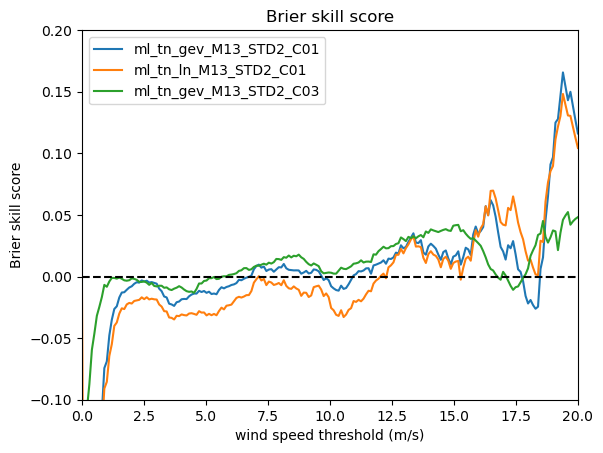

In [88]:
values = np.linspace(0, 20, 200)
ylim = [-0.1, 0.2]
make_brier_skill_plot(base_model, ml_spatial_models, X_test, y_test, variances_test, values, ylim=ylim)


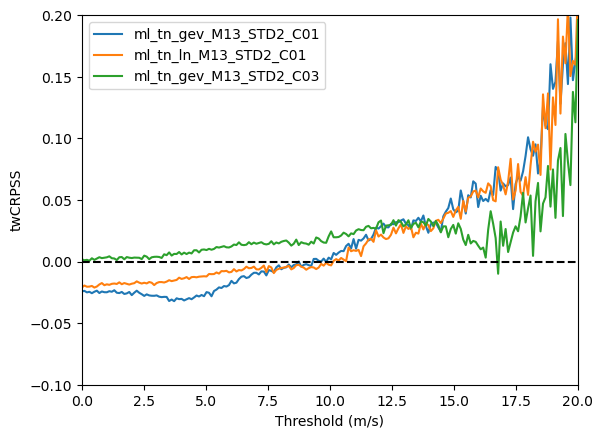

In [55]:
values = np.linspace(0, 20, 200)
ylim = [-0.1, 0.2]
make_twcrpss_plot(base_model, ml_spatial_models, X_test, y_test, variances_test, values, ylim=ylim)

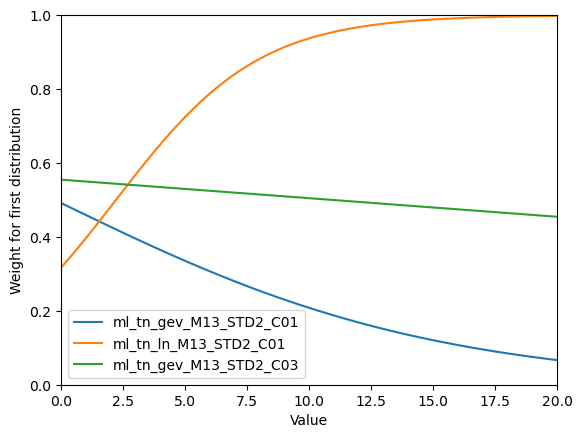

In [56]:
plot_weight_mixture(ml_spatial_models, values)

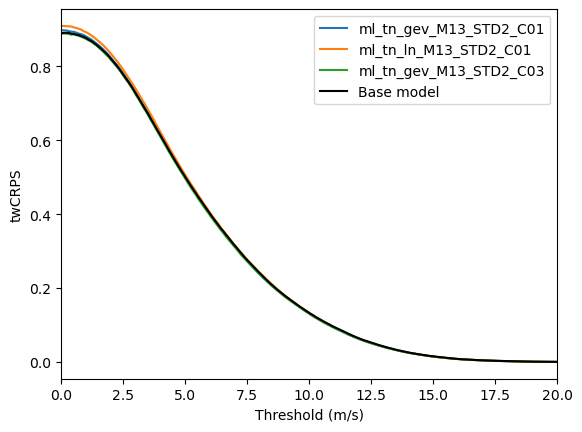

In [14]:
values = np.linspace(0, 20, 200)
ylim = [0, 0.05]
ylim = None
make_twcrps_plot(ml_spatial_models, X_test, y_test, variances_test, values, ylim=ylim, base_model=base_model)

In [13]:
threshold = 15
print("Base model twCRPS: ", base_model.twCRPS(X_test, y_test, variances_test, threshold, 1000).numpy())
for name, model in ml_spatial_models.items():
    print(name, " twCRPS: ", model.twCRPS(X_test, y_test, variances_test, threshold, 1000).numpy())

Base model twCRPS:  0.015134968
ml_tn_gev_M13_STD2_C01  twCRPS:  0.014653844
ml_tn_ln_M13_STD2_C01  twCRPS:  0.014667828
ml_tn_gev_M13_STD2_C03  twCRPS:  0.0150064565


There are 7780 values in the PIT diagram


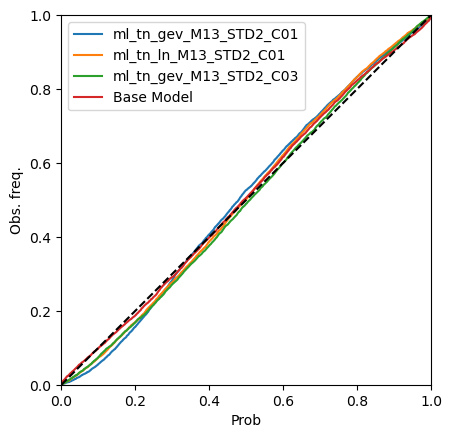

In [89]:
t = 0
make_cpit_diagram_emos(ml_spatial_models, X_test, y_test, variances_test, t=t, base_model=base_model)

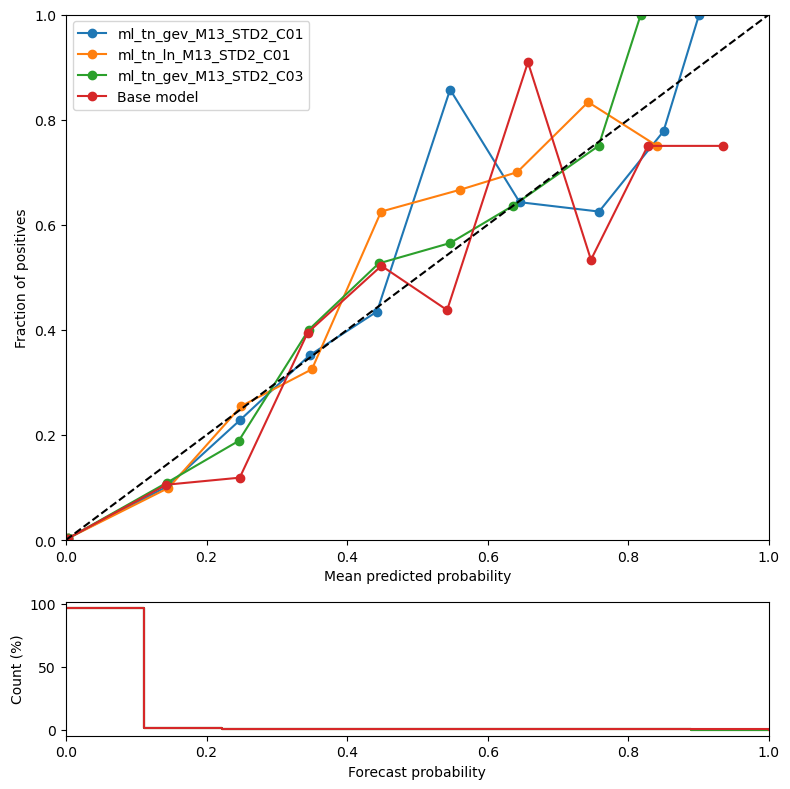

In [80]:
t=15
make_reliability_and_sharpness(ml_spatial_models, X_test, y_test, variances_test, t, base_model=base_model)

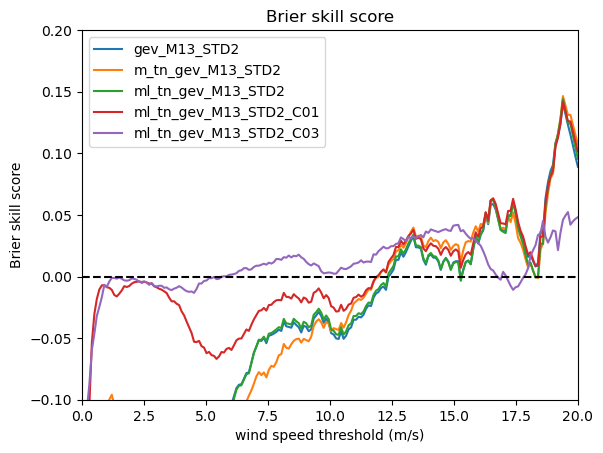

In [17]:
values = np.linspace(0, 20, 200)
ylim = [-0.1, 0.2]
make_brier_skill_plot(base_model, progression_models, X_test, y_test, variances_test, values, ylim=ylim)

Now the variance/scale parameters of all of the distributions are estimated using 

$\sigma = c + d \cdot S^2$

where $S^2$ is the spatial variance. However, we could also consider using the features to estimate the spatial variance,

$\sigma = c + dX$

Regarding the names, if there is an f after the distibution (such as tnf), then the variance is estimated using the features.

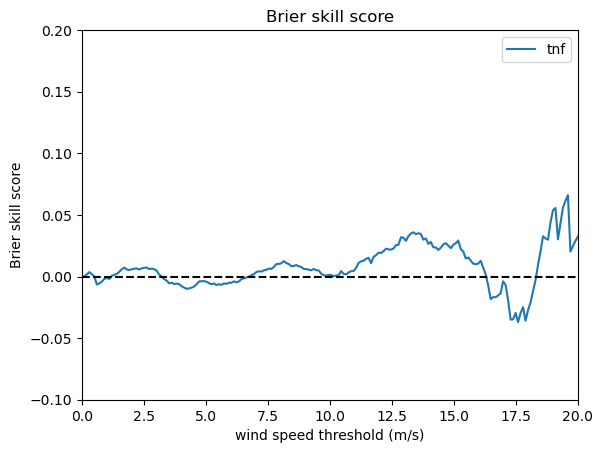

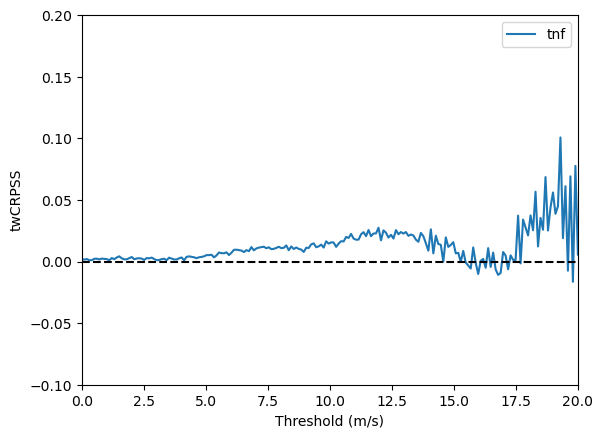

In [24]:
make_brier_skill_plot(base_model, tnf_dict, X_test, y_test, variances_test, values, ylim=ylim)
make_twcrpss_plot(base_model, tnf_dict, X_test, y_test, variances_test, values, ylim=ylim)

In [62]:
base_model = tnf

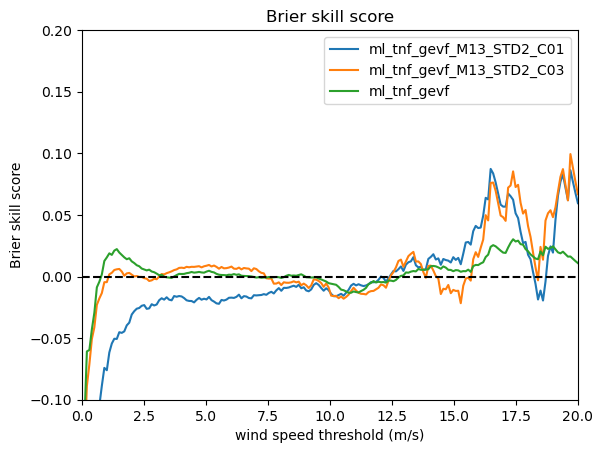

In [58]:
base_model = tnf
ylim = [-0.1, 0.2]
make_brier_skill_plot(base_model, ml_tnf_gevf_models, X_test, y_test, variances_test, values, ylim=ylim)


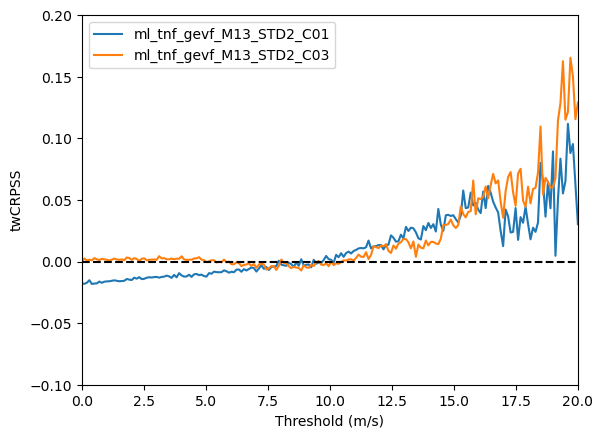

In [99]:
make_twcrpss_plot(base_model, ml_tnf_gevf_models, X_test, y_test, variances_test, values, ylim=ylim)

There are 848 values in the PIT diagram


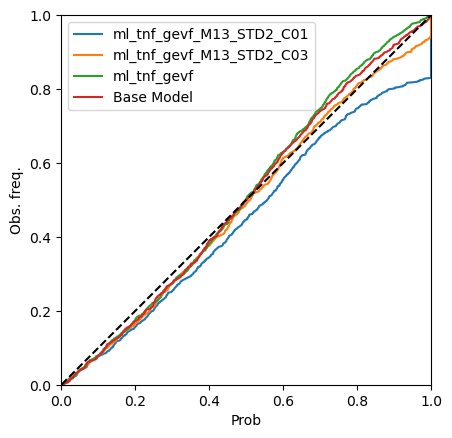

In [105]:
t = 10
make_cpit_diagram_emos(ml_tnf_gevf_models, X_test, y_test, variances_test, t=t, base_model=base_model)

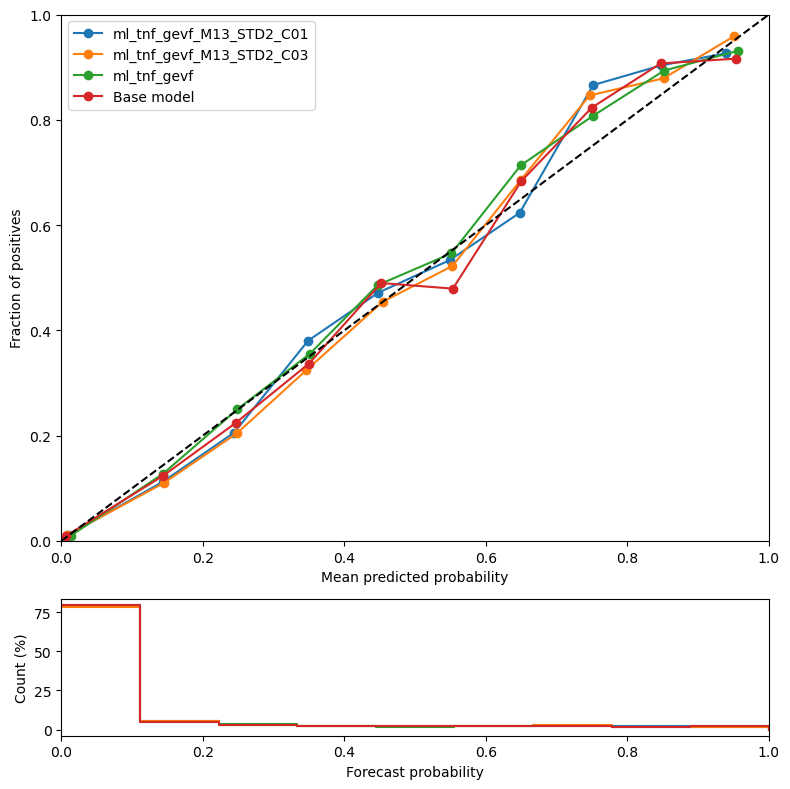

In [61]:
t = 10
make_reliability_and_sharpness(ml_tnf_gevf_models, X_test, y_test, variances_test, t, base_model=base_model)

Now let's take a closer look at the data. There is one seperate fold for testing, which is seperate for now. There are three folds to train on:

- Fold 1: Oct 2015 - Mar 2016
- Fold 2: Oct 2016 - Mar 2017
- Fold 3: Jan - Mar 2015 and Oct - Dec 2017

- Testing: Nov 2018 - Mar 2019 and Oct, Nov 2019

Some statistics:


In [40]:
X_1, y_1, variances_1 = get_tensors(base_model.neighbourhood_size, base_model.all_features, 1, ignore)
X_2, y_2, variances_2 = get_tensors(base_model.neighbourhood_size, base_model.all_features, 2, ignore)
X_3, y_3, variances_3 = get_tensors(base_model.neighbourhood_size, base_model.all_features, 3, ignore)

In [41]:
quantile = 0.98
print('The {} quantile of y_1 is: {}'.format(quantile, np.quantile(y_1, quantile)))
print('The {} quantile of y_2 is: {}'.format(quantile, np.quantile(y_2, quantile)))
print('The {} quantile of y_3 is: {}'.format(quantile, np.quantile(y_3, quantile)))

threshold = 17
print("There are {} observations in y_1 exceeding the threshold of {}".format(np.sum(y_1 > threshold), threshold))
print("There are {} observations in y_2 exceeding the threshold of {}".format(np.sum(y_2 > threshold), threshold))
print("There are {} observations in y_3 exceeding the threshold of {}".format(np.sum(y_3 > threshold), threshold))


The 0.98 quantile of y_1 is: 14.896119537353513
The 0.98 quantile of y_2 is: 12.0
The 0.98 quantile of y_3 is: 14.100000381469727
There are 54 observations in y_1 exceeding the threshold of 17
There are 12 observations in y_2 exceeding the threshold of 17
There are 31 observations in y_3 exceeding the threshold of 17


Training on fold 2 & 3

In [32]:
base_model = load_model(folder + 'trunc_normal/tn_crps__epochs600_folds_2_3.pkl')

tn_M13_STD2 = load_model(folder + 'trunc_normal/tn_twcrps_mean13.0_std2.0_epochs600_folds_2_3.pkl')

gev_M13_STD2 = load_model(folder + 'gev_spatial_variance/gev_spatial_variance_twcrps_mean13.0_std2.0_epochs600_folds_2_3.pkl')

ml_tn_gev_M13_STD2_C01 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_sv_twcrps_mean13.0_std2.0_constant0.009999999776482582_epochs600_folds_2_3.pkl')

ml_tn_gev_M13_STD2_C03 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_sv_twcrps_mean13.0_std2.0_constant0.029999999329447746_epochs600_folds_2_3.pkl')

ml_tn_gev_M11_STD2_C02 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_sv_twcrps_mean11.0_std2.0_constant0.019999999552965164_epochs600_folds_2_3.pkl')

tnf = load_model(folder + 'trunc_normal_features/tnf_twcrps_mean11.0_std2.0_constant0.019999999552965164_epochs600_folds_2_3.pkl')

models = {'ml_tn_gev_M13_STD2_C01': ml_tn_gev_M13_STD2_C01, 'ml_tn_gev_M13_STD2_C03': ml_tn_gev_M13_STD2_C03, 'ml_tn_gev_M11_STD2_C02': ml_tn_gev_M11_STD2_C02, 'tn_M13_STD2': tn_M13_STD2, 'gev_M13_STD2': gev_M13_STD2, 'tnf':tnf}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution with spatial variance
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution with spatial variance
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution with spatial variance
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution with spatial variance
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution with features


In [28]:
X_test, y_test, variances_test = get_tensors(base_model.neighbourhood_size, base_model.all_features, 1, ignore)
X_test = (X_test - base_model.feature_mean) / base_model.feature_std

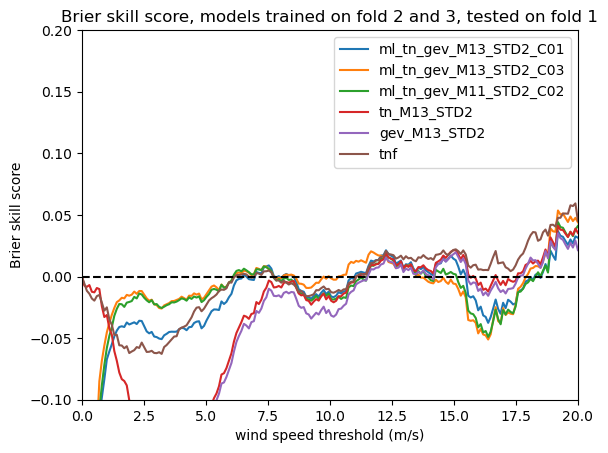

In [33]:
ylim = [-0.1, 0.2]
make_brier_skill_plot(base_model, models, X_test, y_test, variances_test, values, ylim=ylim, title='Brier skill score, models trained on fold 2 and 3, tested on fold 1')

Training on fold 1 & 3

In [27]:
base_model = load_model(folder + 'trunc_normal/tn_crps__epochs600_folds_1_3.pkl')

ml_tn_gev_M13_STD2_C01 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_sv_twcrps_mean13.0_std2.0_constant0.009999999776482582_epochs600_folds_1_3.pkl')

ml_tn_gev_M13_STD2_C03 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_sv_twcrps_mean13.0_std2.0_constant0.029999999329447746_epochs600_folds_1_3.pkl')

models = {'ml_tn_gev_M13_STD2_C01': ml_tn_gev_M13_STD2_C01, 'ml_tn_gev_M13_STD2_C03': ml_tn_gev_M13_STD2_C03}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution with spatial variance
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution with spatial variance
Using given weight parameters for weights in Mixture Linear distribution


In [28]:
X_test, y_test, variances_test = get_tensors(base_model.neighbourhood_size, base_model.all_features, 2, ignore)
X_test = (X_test - base_model.feature_mean) / base_model.feature_std


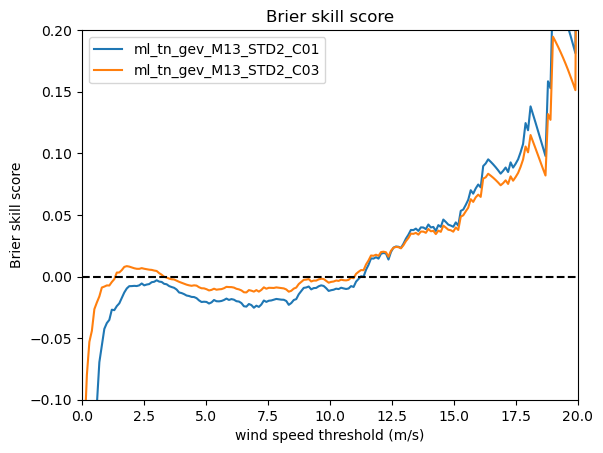

In [29]:
make_brier_skill_plot(base_model, models, X_test, y_test, variances_test, values, ylim=ylim)